#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

## 先用所有因子跑回歸

In [1]:
import pandas as pd

In [20]:
# 讀檔
dataset = pd.read_csv('insurance.csv')

In [21]:
# 觀察資料集
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [22]:
# 轉化類別資料
dataset['sex'] = dataset['sex'].apply({'male':0, 'female':1}.get)
dataset['smoker'] = dataset['smoker'].apply({'yes':1, 'no':0}.get)
# 地區新增兩欄 南北 以及 東西
dataset['region_ns'] = dataset['region'].apply({'southwest':0, 'southeast':0, 'northwest':1, 'northeast':1}.get)
dataset['region_ew'] = dataset['region'].apply({'southwest':0, 'southeast':1, 'northwest':0, 'northeast':1}.get)

In [23]:
# drop region 欄位
dataset.drop(columns=['region'], inplace=True)
dataset.head()

# 把charges 移到最後面
dataset.insert(len(dataset.columns)-1,'charges', dataset.pop('charges'))
dataset.head()

,age,sex,bmi,children,smoker,region_ns,region_ew,charges
0,19,1,27.900,0,1,0,0,16884.92400
1,18,0,33.770,1,0,0,1,1725.55230
2,28,0,33.000,3,0,0,1,4449.46200
3,33,0,22.705,0,0,1,0,21984.47061
4,32,0,28.880,0,0,1,0,3866.85520


In [79]:
# 取出charge 當作y 設定為欄向量
y = dataset.iloc[:, 7].values.reshape(-1,1)
print(y)
# 剩下的當作x
x = dataset.iloc[:, 0:7].values
x

[[16884.924 ]
 [ 1725.5523]
 [ 4449.462 ]
 ...
 [ 1629.8335]
 [ 2007.945 ]
 [29141.3603]]


array([[19.  ,  1.  , 27.9 , ...,  1.  ,  0.  ,  0.  ],
       [18.  ,  0.  , 33.77, ...,  0.  ,  0.  ,  1.  ],
       [28.  ,  0.  , 33.  , ...,  0.  ,  0.  ,  1.  ],
       ...,
       [18.  ,  1.  , 36.85, ...,  0.  ,  0.  ,  1.  ],
       [21.  ,  1.  , 25.8 , ...,  0.  ,  0.  ,  0.  ],
       [61.  ,  1.  , 29.07, ...,  1.  ,  1.  ,  0.  ]], shape=(1338, 7))

In [80]:
# 分割訓練集與預測集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 25)

In [45]:
# 檢視訓練集與預測集
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(936, 7)
Shape of X_test:(402, 7)
Shape of y_train:(936, 1)
Shape of y_test(402, 1)


In [46]:
# 檢查空值
dataset.isnull().sum()

age          0
sex          0
bmi          0
children     0
smoker       0
region_ns    0
region_ew    0
charges      0
dtype: int64

In [47]:
# 基礎統計數據
dataset.describe() 

,age,sex,bmi,children,smoker,region_ns,region_ew,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,0.485052,0.514200,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,0.499963,0.499985,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,0.000000,0.000000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,0.000000,0.000000,1.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,1.000000,1.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,63770.428010


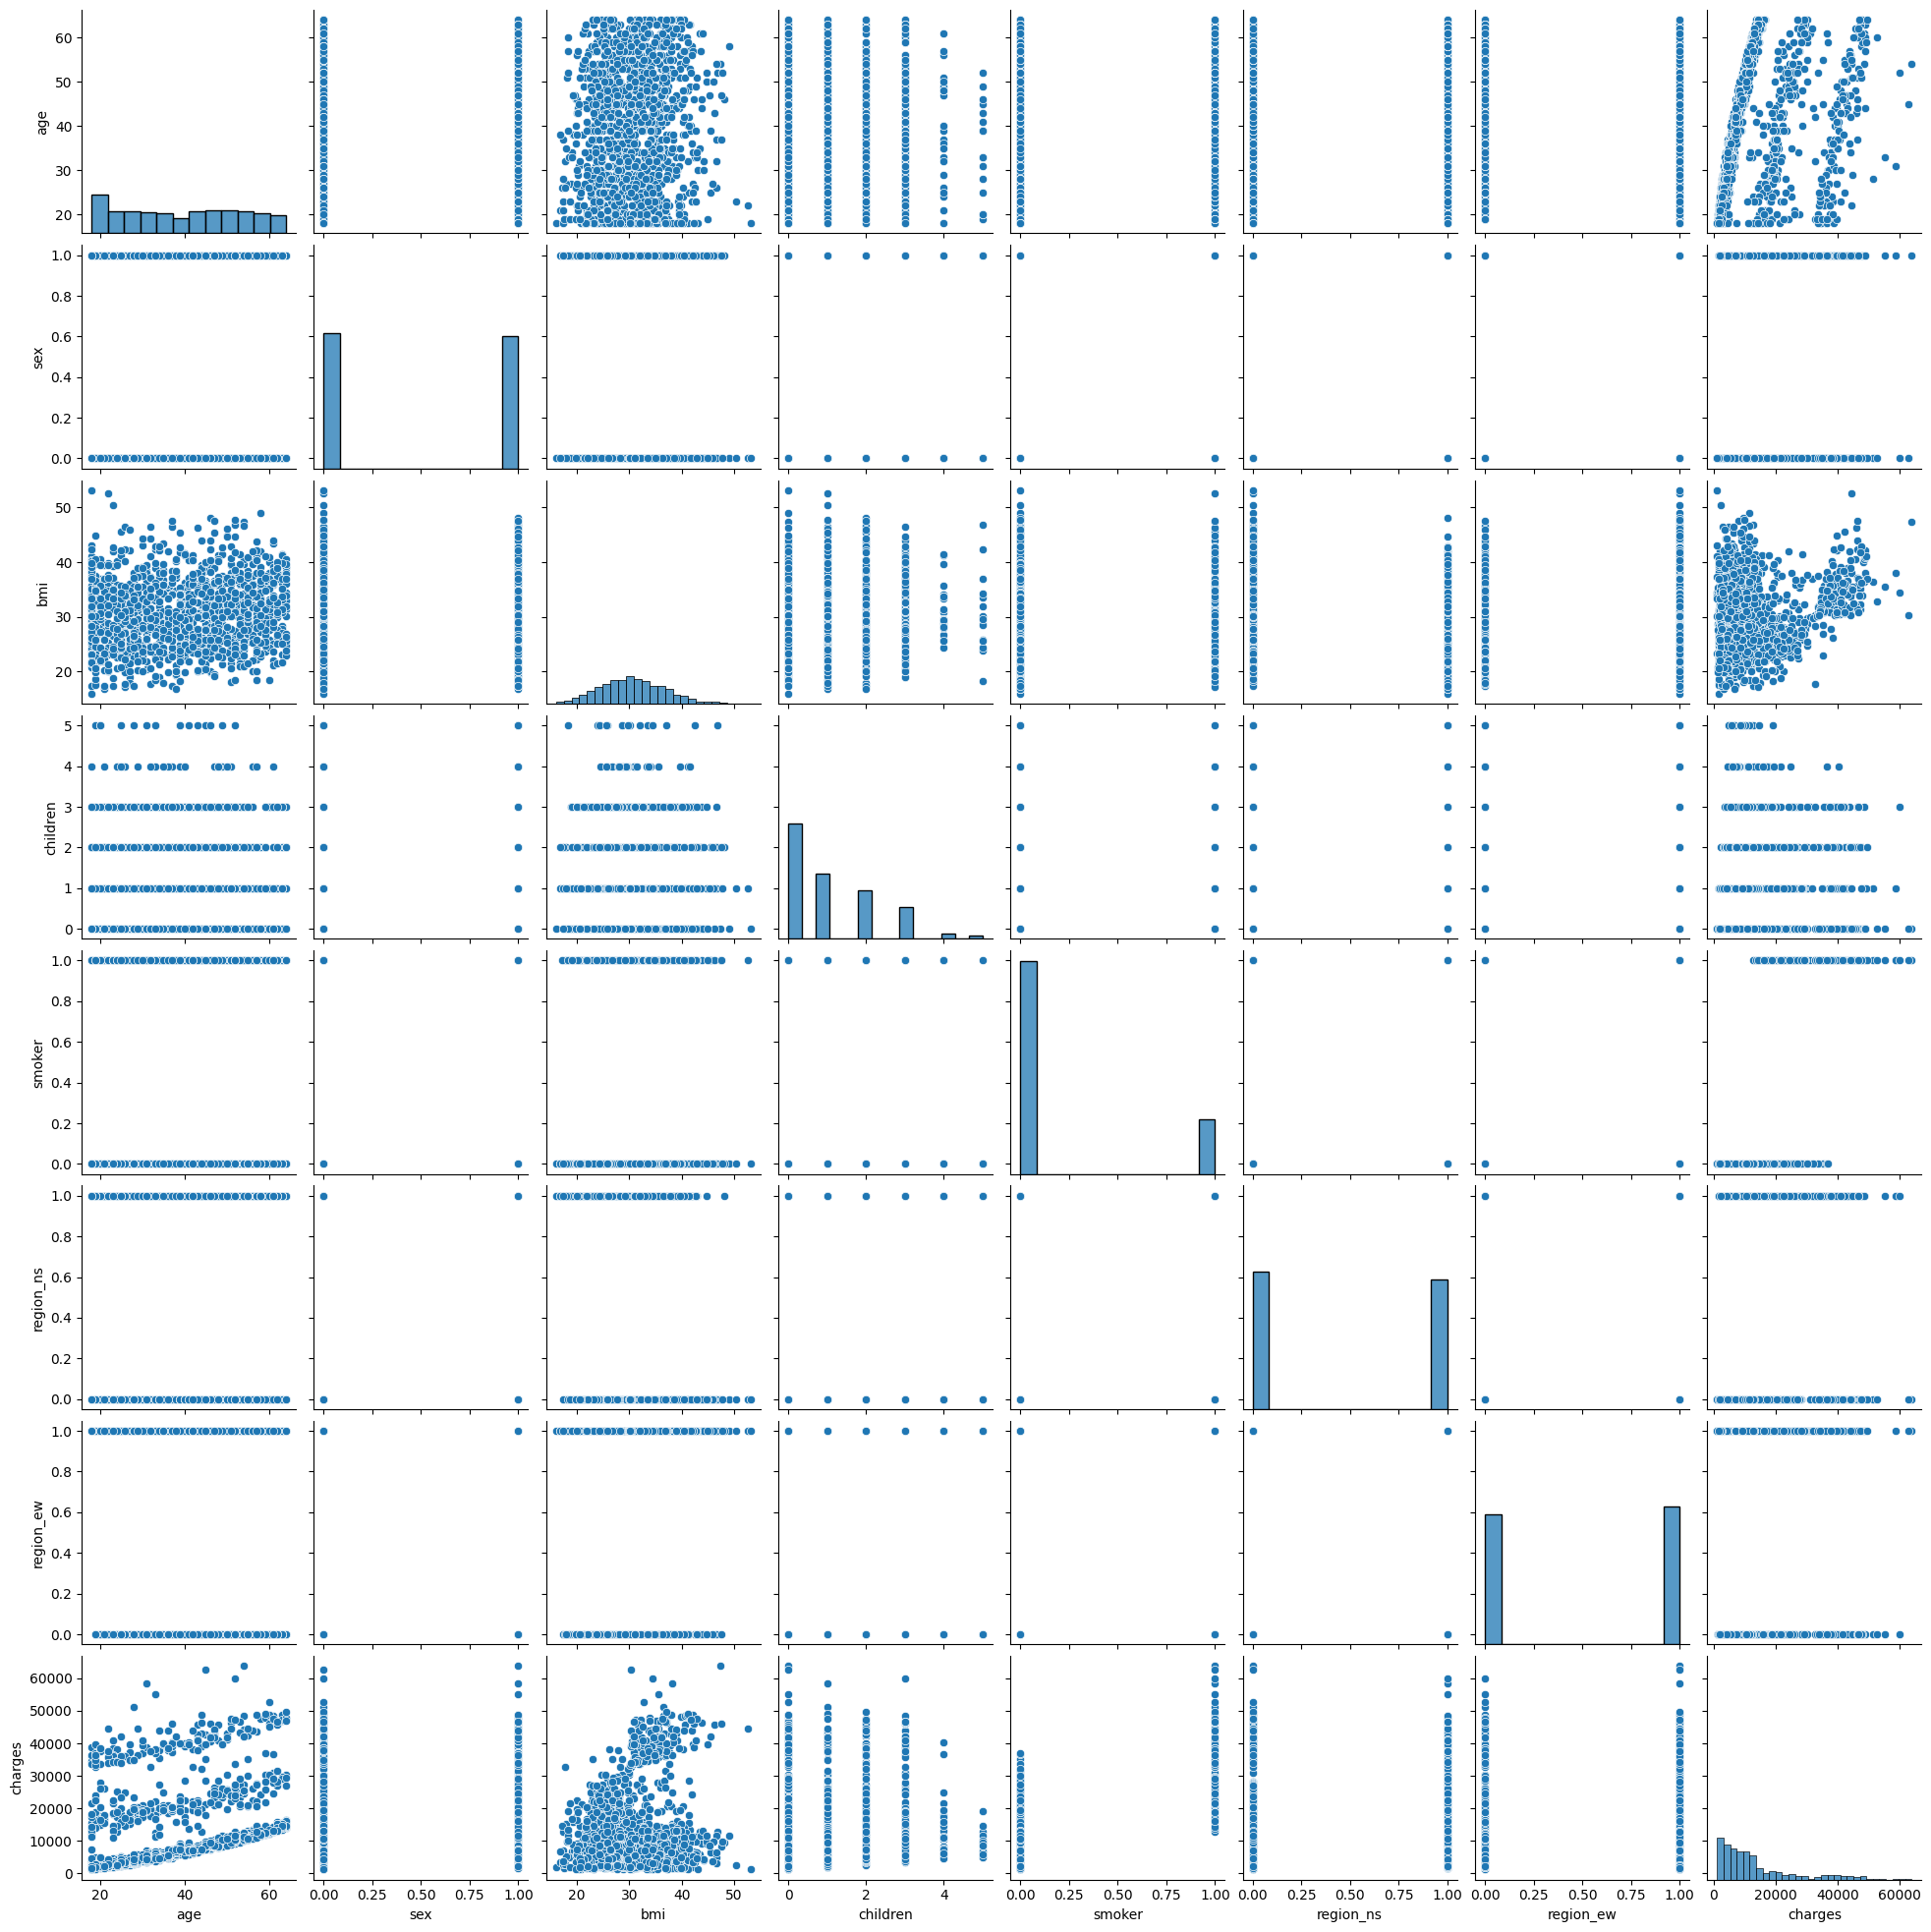

In [48]:
# 觀察X與Y的線性關係
import seaborn as sns
sns.pairplot(dataset[['age', 'sex', 'bmi', 'children', 'smoker', 'region_ns', 'region_ew','charges']])

<Axes: >

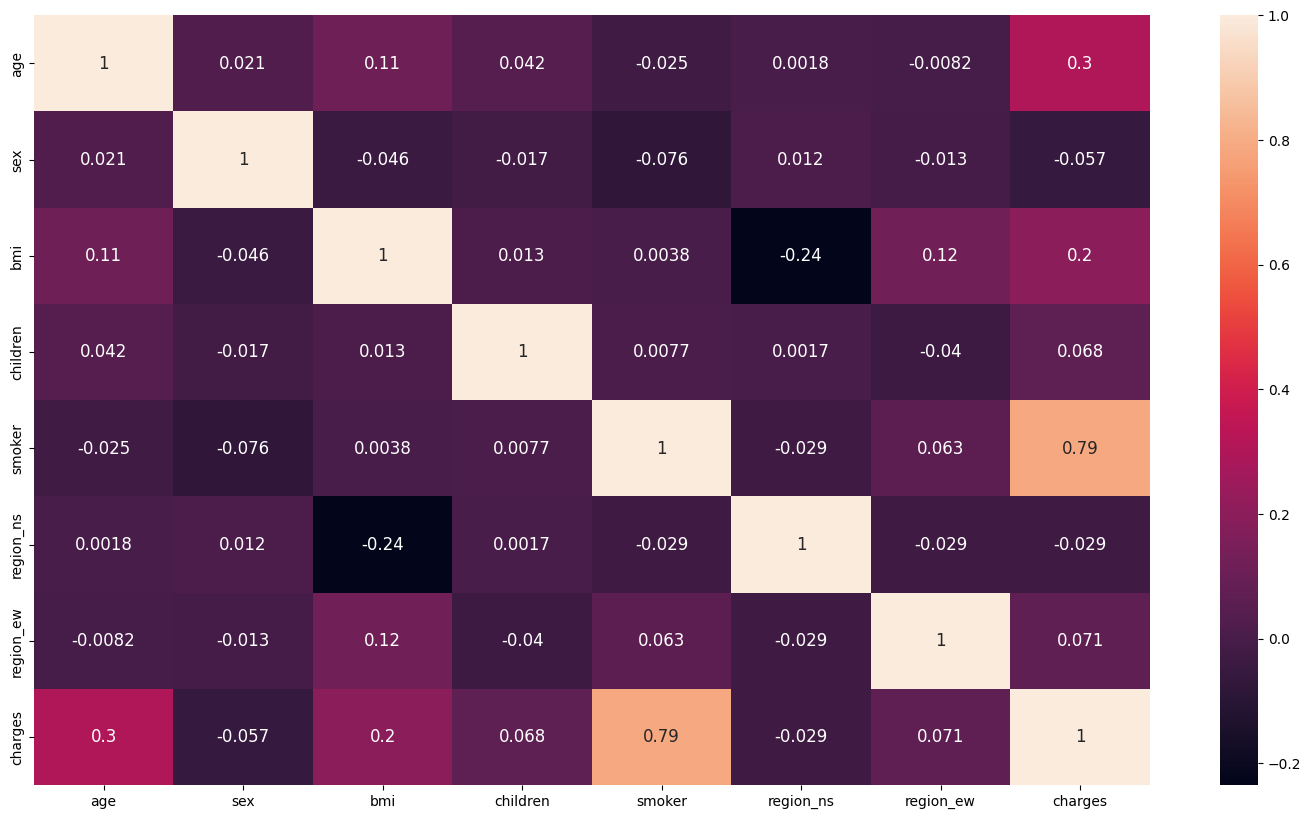

In [52]:
# 觀察相關係數
import matplotlib.pyplot as plt
corrmat = dataset.corr()
fig, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

In [49]:
# 建立回歸模型
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

In [50]:
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error
# R2 score，即決定係數，反映Y的全部變異能通過迴歸關係被所有X解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# 越低越好
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.7575613897832577
R2_score (test):  0.731038198931202
RMSE:  5941.22523575346
RMSE:  6323.904130967681


In [40]:
import statsmodels.api as sm
from scipy import stats

In [51]:
# 看回歸結果細項
X2 = sm.add_constant(x)
est = sm.OLS(y, X2).fit()
print(est.summary())

# x5 抽菸因子的影響度最高

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     572.6
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:56:24   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1330   BIC:                         2.715e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.308e+04   1030.214    -12.693      0.0

- x5 抽菸因子的影響度最高

In [53]:
# 對照欄位
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   region_ns  1338 non-null   int64  
 6   region_ew  1338 non-null   int64  
 7   charges    1338 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [68]:
# 自己設定一個條件進行預測 31歲 男性 bmi 25.74 沒有小孩 不抽菸 住在西南
to_be_predicted = np.array([
    [31., 1. , 25.74, 0. , 0., 0., 0. ]
])
predicted_price = regressor_linear.predict(to_be_predicted)
predicted_price

array([[3529.33769926]])

## 去除不顯著變數 再跑一次回歸

In [73]:
# 重新賦值X 去掉不顯著的變數與y
x = dataset.drop(columns=['sex','region_ew','charges']).values
x

array([[19.  , 27.9 ,  0.  ,  1.  ,  0.  ],
       [18.  , 33.77,  1.  ,  0.  ,  0.  ],
       [28.  , 33.  ,  3.  ,  0.  ,  0.  ],
       ...,
       [18.  , 36.85,  0.  ,  0.  ,  0.  ],
       [21.  , 25.8 ,  0.  ,  0.  ,  0.  ],
       [61.  , 29.07,  0.  ,  1.  ,  1.  ]], shape=(1338, 5))

In [74]:
# 分割訓練集與預測集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 25)

In [75]:
# 建立回歸模型
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

In [76]:
# 結果幾乎沒差
# R2 score，即決定係數，反映Y的全部變異能通過迴歸關係被所有X解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
# 越低越好
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.7575604120686782
R2_score (test):  0.7310482465963433
RMSE:  5941.237215727836
RMSE:  6323.7860081259305


## 跑polynomial regression

In [54]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

LinearRegression()

In [55]:
# 跑polynomial regression
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.8540077144630556
R2_score (test):  0.8266086101497124
RMSE:  4610.41562042872
RMSE:  5077.544511139372


In [69]:
# 自己設定一個條件進行預測 31歲 男性 bmi 25.74 沒有小孩 不抽菸 住在西南
to_be_predicted = np.array([
    [31., 1. , 25.74, 0. , 0., 0., 0. ]
])

predicted_price = regressor_poly2.predict(poly_reg.fit_transform(to_be_predicted))
predicted_price

array([[4643.28293635]])

## 跑Lasso 跟 Ridge

In [77]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
# 跑Lasso 跟 Ridge 前 回去使用所有的x
x = dataset.iloc[:, 0:7].values
# 分割訓練集與預測集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 25)

In [81]:
# 跑Lasso 結論跟上面的結果差不多
lasso = Lasso(alpha = 0.5) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print("coef：")
for i, j in zip(dataset.columns, lasso.coef_):
    print(i, j)

coef：
age 260.7602237363493
sex 13.958740482762204
bmi 319.970349360566
children 444.247186594119
smoker 24445.053267459185
region_ns 1400.211319521093
region_ew -15.634615299505347


In [82]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.7575613527514642
R2_score (test): 0.7310655104678705
train_RMSE:  5941.225689505892
test_RMSE:  6323.583044620723


In [83]:
# 跑 ridge 結論跟上面的結果差不多
ridgeReg = Ridge(alpha=0.5)

ridgeReg.fit(X_train, y_train)

y_pred_ridge_train = ridgeReg.predict(X_train)
r2_score_ridge_train = ridgeReg.score(X_train, y_train)

y_pred_ridge_test = ridgeReg.predict(X_test)
r2_score_ridge_test = ridgeReg.score(X_test, y_test)

rmse_ridge_train = (np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)))
rmse_ridge_test = (np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)))

print("coef：")
for i, j in zip(dataset.columns, ridgeReg.coef_):
    print(i, j)

coef：
age 260.6860506893553
sex 11.777763533947317
bmi 320.0554978105725
children 445.13471974053783
smoker 24363.98946713398
region_ns 1398.085609770111
region_ew -14.603747831865537


In [84]:
print("R2_score (train): ",r2_score_ridge_train)
print("R2_score (test):", r2_score_ridge_test)
print("train_RMSE: ", rmse_ridge_train)
print("test_RMSE: ", rmse_ridge_test)

R2_score (train):  0.7575538031823946
R2_score (test): 0.7314258758110759
train_RMSE:  5941.318194032351
test_RMSE:  6319.344904556365
